# Capstone 3: Customer Segmentation pt. 2

## Modeling

In this notebook, we will try out several different models (using different algorithms and subsets of our data) in an attempt to find the best method of segmentation. We'll then go back to our full customer dataset to begin interpreting the results, defining the unique characteristics of each segment.

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
# Read in our model-ready data, which is the log values of the customer DataFrame.
df = pd.read_csv("log_customers.csv", index_col=0)
df

,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time,region_Europe,region_Other,region_UK
CustomerID,,,,,,,,,,
12346.0,2.584963,2.222392,6.693487,3.434295,6.019257,8.348728,7.335390,0,0,1
12347.0,3.000000,4.982994,3.672425,9.459770,12.459770,1.584963,5.857981,1,0,0
12348.0,2.321928,3.201634,0.536053,8.373648,10.695576,6.247928,6.515700,1,0,0
12349.0,2.000000,5.467606,5.320124,9.835474,11.835474,4.247928,8.159871,1,0,0
12350.0,0.000000,4.000000,1.560715,8.201634,8.201634,8.280771,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...
18283.0,4.459432,5.483083,3.995485,6.955623,11.415055,2.000000,4.985045,0,0,1
18284.0,0.000000,4.754888,2.087463,8.685380,8.685380,8.754888,0.000000,0,0,1
18285.0,0.000000,3.459432,3.902074,8.558421,8.558421,9.368506,0.000000,0,0,1


In [122]:
customers = pd.read_csv("customers.csv")
customers

,CustomerID,country,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time
0,12346.0,United Kingdom,6,4.666667,103.50,10.810000,64.86,326,160.50
1,12347.0,Iceland,8,31.625000,12.75,704.165000,5633.32,3,57.00
2,12348.0,Finland,5,9.200000,1.45,331.680000,1658.40,76,90.50
3,12349.0,Italy,4,44.250000,39.95,913.635000,3654.54,19,285.00
4,12350.0,Norway,1,16.000000,2.95,294.400000,294.40,311,0.00
...,...,...,...,...,...,...,...,...,...
5836,18283.0,United Kingdom,22,44.727273,15.95,124.122727,2730.70,4,30.67
5837,18284.0,United Kingdom,1,27.000000,4.25,411.680000,411.68,432,0.00
5838,18285.0,United Kingdom,1,11.000000,14.95,377.000000,377.00,661,0.00
5839,18286.0,United Kingdom,3,23.000000,24.95,379.476667,1138.43,477,247.00


In [4]:
df.describe()

,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time,region_Europe,region_Other,region_UK
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,1.932849,3.815673,3.598121,7.879718,9.812568,6.335418,4.406934,0.078582,0.010615,0.910803
std,1.557384,1.293144,1.234727,1.058126,1.998435,2.339200,3.003299,0.269109,0.102488,0.285052
min,0.000000,0.000000,-2.556393,-0.048910,1.536053,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.115477,3.087463,7.279564,8.398701,4.643856,0.000000,0.000000,0.000000,1.000000
50%,2.000000,3.906891,3.672425,7.876503,9.756840,6.539159,5.554589,0.000000,0.000000,1.000000
75%,3.000000,4.643856,4.083213,8.488399,11.124050,8.558421,6.681871,0.000000,0.000000,1.000000
max,8.879583,8.227404,10.867171,13.536349,19.206611,9.529431,9.481799,1.000000,1.000000,1.000000


### ***K-Means***
First, a K-Means approach using all features in the dataset. We'll look at inertia (sum of squared distance to cluster center) as well as silhouette score to find the best number of clusters, k.

In [5]:
# Set range of possible k
ks = range(2, 11)

# Lists to collect relevant scores
inertias = []
sil = []

# loop over values of k, instantiate a model, and append the scores to our lists
for k in ks:
    model = KMeans(n_clusters=k, init='random', random_state=36)
    model.fit(df)
    inertias.append(model.inertia_)
    sil.append(silhouette_score(df, model.labels_))

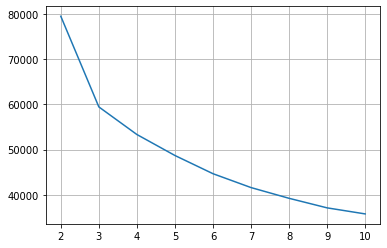

In [6]:
# Plot Sum-of-squares for each k, looking for the elbow value
plt.grid()
plt.plot(ks, inertias);

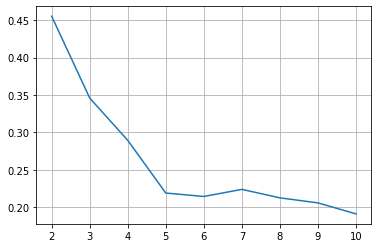

In [7]:
# Plot silhouette score for each k, looking for a reasonably high score
plt.grid()
plt.plot(ks, sil)

The elbow in the inertia graph seems to indicate 3 as the ideal number of clusters. The silhouette score is best at 2 segments, but is still decent at 3 or 4 segments (especially considering our goal of customer segments, which do not necessarily need to be so tightly defined). Let's take a closer look at the outcomes for 3 and 4 clusters. We can get a sense of how intuitive the clustering is by using PCA to reduce our data to 2D and graphing the result, with cluster labels separated by color.

In [8]:
# Choose colors for up to 6 clusters, plus -1
colors = ['darkcyan', 'black', 'gold', 'darkmagenta', 'coral', 'silver', 'lime']

Inertia: 59451.93327938729
Silhouette Score: 0.3458704906586819


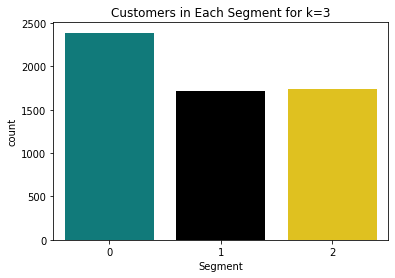

In [88]:
# Fit the model with k=3
km3_model = KMeans(n_clusters=3, random_state=36)
km3_model.fit(df)
km3_sil = silhouette_score(df, km3_labels)

# Get cluster labels, and print inertia and silhouette score
km3_labels = pd.Series(km3model.labels_)
print("Inertia: {}\nSilhouette Score: {}".format(km3_model.inertia_, km3_sil))

# Graph a countplot of customers in each segment
sns.countplot(x=km3_labels, palette=colors[:3])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=3');

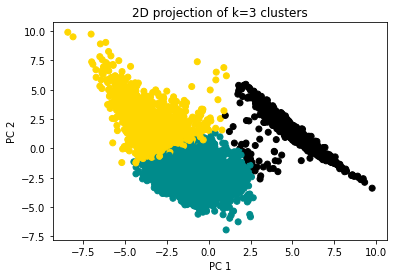

In [86]:
# Use PCA to reduce data to 2D for cluster visualization
pca = PCA(n_components=2)
pca.fit(df)
components = pca.transform(df)

# Set first two principal components for x and y values
pcax = components[:,0]
pcay = components[:,1]

# Scatterplot of first two principal components colored by segment
colorlist = [colors[s] for s in km3_labels]
plt.scatter(pcax, pcay, c=colorlist)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D projection of k=3 clusters');

Inertia: 53349.50112752091
Silhouette Score: 0.2892651052825204


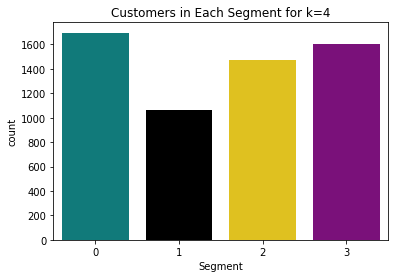

In [89]:
# Try another model with k=4
km4_model = KMeans(n_clusters=4, random_state=36)
km4_model.fit(df)
km4_sil = silhouette_score(df, km4_labels)

km4_labels = pd.Series(km4_model.labels_)
print("Inertia: {}\nSilhouette Score: {}".format(km4_model.inertia_, km4_sil))

sns.countplot(x=km4_labels, palette=colors[:4])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=4');

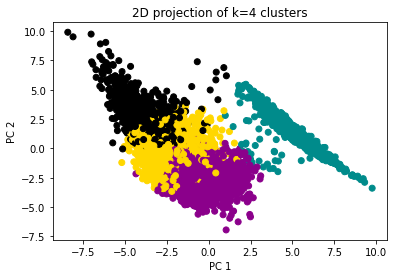

In [91]:
colorlist = [colors[s] for s in km4_labels]
plt.scatter(pcax, pcay, c=colorlist)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D projection of k=4 clusters');

In our 2D scatterplot, there does appear to be a clearly identifiable long, thin cluster to the right (representing about 1600 customers), with the rest in a larger teardrop-shaped mass to the left. Based on the EDA performed in the previous notebook for this project, the thin cluster is probably associated with customers with avg_order_time of 0.

Both models identify the thin cluster with a few extra points that appear to be closer to the teardrop (remember this 2D plot is an oversimplified version of the 10D data), then seperate the teardrop into 2 or 3 additional clusters. Although the 4-cluster model segments are less well-defined, it may still be helpful to keep this teardrop middle-cluster (the yellow group in the scatterplot directly above) when we move on to interpreting the underlying customer segments. At that time, we can decide whether there is a benefit to the 4 groups, or if 3 groups is sufficient.

However, we still need to try out a few more models before we settle on the best segmentation. Next, let's continue using K-Means but with a subset of our data. A traditional RFM analysis would contain just these three features - Recency, Frequency, and Monetary Value.

In [117]:
# df of only RFM features
rfm = df[['recency', 'orders', 'avg_order_time', 'total_value']]

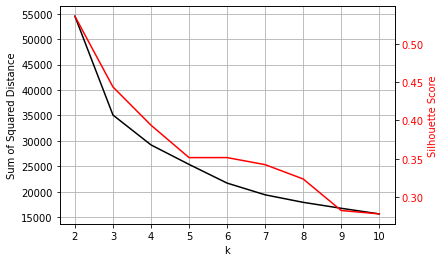

In [118]:
# Repeat methods to find optimal k value
inertias = []
sil = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=36)
    model.fit(rfm)
    inertias.append(model.inertia_)
    sil.append(silhouette_score(rfm, model.labels_))
    
# Plot inertia and sil scores
fig, ax1 = plt.subplots()
plt.grid()

ax1.plot(ks, inertias, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylabel('Sum of Squared Distance', color='k')
ax1.set_xlabel('k')

ax2 = ax1.twinx()
ax2.plot(ks, sil, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Silhouette Score', color='r')

plt.show()

Inertia: 21698.02269607196
Silhouette Score: 0.35160447971779163


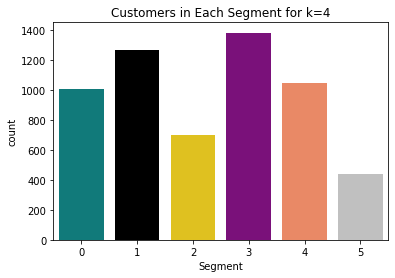

In [119]:
# Optimal k=4. Repeat method to visualize cluster size and 2D scatter:

# Fit model to rfm, get labels, print scores
rfm_km_model = KMeans(n_clusters=6, random_state=36)
rfm_km_model.fit(rfm)
rfm_km_labels = pd.Series(rfm_km_model.labels_)
rfm_km_sil = silhouette_score(rfm, rfm_km_labels)

print("Inertia: {}\nSilhouette Score: {}".format(rfm_km_model.inertia_, rfm_km_sil))

sns.countplot(x=rfm_km_labels, palette=colors[:6])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=4');

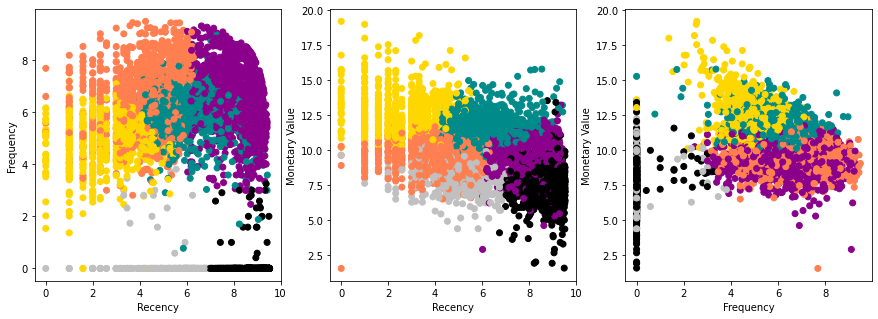

In [120]:
# Because the data is only 3D, we don't need to do dimension reduction, 
# we can simply plot three graphs--one for each feature pair
# Scatterplot of clusters
colorlist = [colors[s] for s in rfm_km_labels]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(rfm.recency, rfm.avg_order_time, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(rfm.recency, rfm.total_value, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Monetary Value')

plt.subplot(1, 3, 3)
plt.scatter(rfm.avg_order_time, rfm.total_value, c=colorlist)
plt.xlabel('Frequency')
plt.ylabel('Monetary Value');

In these graphs, there is no obvious (to the eye) clustering of the data, though there are some distinct lines of points in the lower parts of the axes that are an artifact of the logarithmic scales. The model split the customers into 4 clusters, yet we see the silhouette score is slightly higher than we achieved in the model for the entire dataset.

The benefit of straight RFM analysis is the results will be easy to interpret:
- the <font color='darkmagenta'>**purple**</font> segment above has low recency, low frequency, and low monetary value - these are new/growing customers; 
- the **black** segment has low recency, high frequency, and high value - these are the current loyal customers;
- the <font color='gold'>**yellow**</font> group are the high-value lapsed customers we want to get back;
- and the <font color='darkcyan'>**teal**</font> group are the older customers who only bought once or a few times, then quickly churned.

This analysis is helpful and can lead us to actionable conclusions. However, is there any benefit to including the other features we have? Remember the long, thin cluster in the full dataset - does that segment add anything to our understanding of our customers? One way to check is to use the labels from one model on the scatterplot of the other dataset, and see if the clusters match.

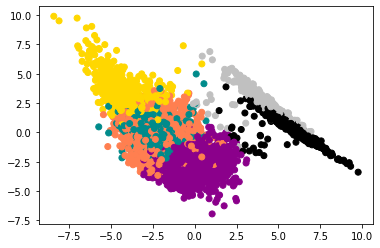

In [121]:
# with the 'colorlist' set to rfm segment labels, let's see how it looks on the PCA of the full dataset.
colorlist = [colors[s] for s in rfm_km_labels]
plt.scatter(pcax, pcay, c=colorlist);

Interestingly, the RFM model splits the thin cluster to the right, primarily between the new customers and quick-churn customers. If the thin cluster represents customers with 0 or low avg_order_time as suspected, this view of RFM segments might tell us something about which new customers are more likely to churn quickly (purple points in the thin cluster), versus eager new customers more likely to develop into loyal customers (purple points mixed in the larger teardrop). Though, we'd have to do more in-depth exploration of the labels to say for sure.

Let's move on to some different clustering models to see if we can capture these differences better.

In [18]:
#df2 = df.drop(columns=['region_UK', 'region_Europe', 'region_Other'])
#df2['rmf_segment'] = rmf_segments.values
#sns.pairplot(df2, hue="rmf_segment", palette=colors[:3])

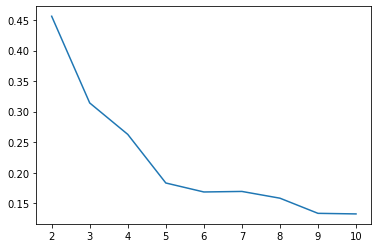

In [71]:
sil = []
for k in ks:
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    labels = model.fit(df).labels_
    sil.append(silhouette_score(df, labels))

plt.plot(ks, sil)

Silhouette Score:  0.31424530776788223


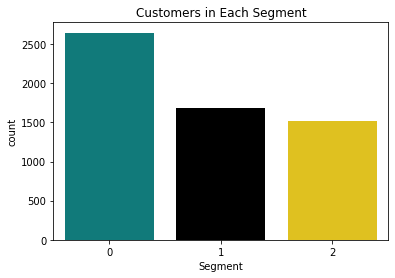

In [95]:
ac3_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
ac3_model.fit(df)
ac3_labels = pd.Series(ac3_model.labels_)
ac3_sil = silhouette_score(df, ac3_labels)

print("Silhouette Score: ",ac3_sil)

sns.countplot(x=ac3_labels, palette=colors[:3])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

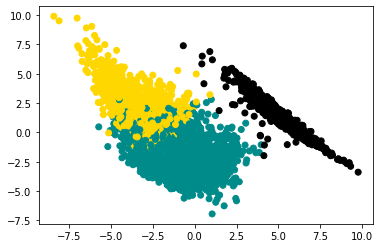

In [96]:
colorlist = [colors[s] for s in ac3_labels]
plt.scatter(pcax, pcay, c=colorlist)

We can see slightly different results for the Agglomerative Clustering model, compared with the K-Means model for k=3. The thin cluster's reach is not as far - there are fewer black points that appear in the 2D projection to be closer to the teardrop. We also see that segment 2 (the yellow group) is smaller in this model than the K-Means model.

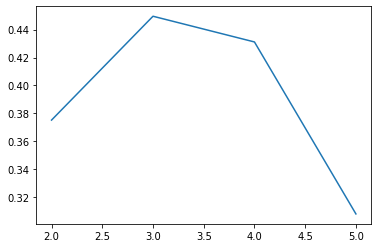

In [22]:
from sklearn.cluster import SpectralClustering
ks=range(2,6)
sil = []
for k in ks:
    model = SpectralClustering(n_clusters=k)
    model.fit(df)
    labels = model.labels_
    sil.append(silhouette_score(df, labels))

plt.plot(ks, sil)

Silhouette Score:  0.43114444644528327


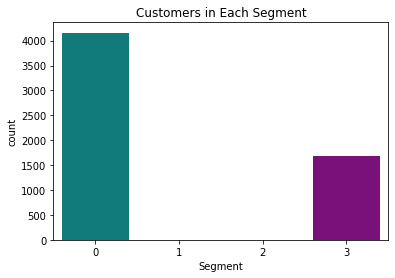

In [100]:
sc_model= SpectralClustering(n_clusters=4)
sc_segments = pd.Series(sc_model.fit(df).labels_)

print("Silhouette Score: ",silhouette_score(df, sc_segments))

sns.countplot(x=sc_segments, palette=colors[:4])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

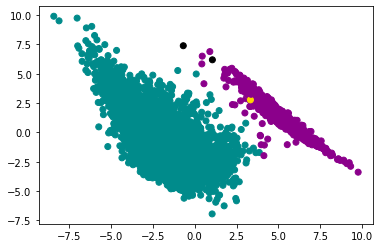

In [101]:
colorlist = [colors[s] for s in sc_segments]
plt.scatter(pcax, pcay, c=colorlist)

In [25]:
windows = range(1, 6)
k_dict = {}
sil_scores = {}
for w in windows:
    model = DBSCAN(eps=w, metric='euclidean', min_samples=2)
    model.fit(df)
    labels = model.labels_
    n_clusters = len(set(model.labels_))
    ks[w] = n_clusters
    try:
        sil_score = round(silhouette_score(df, labels), 3)
    except ValueError:
        sil_score = 'N/A'
    sil_scores[w] = sil_score

for w in sil_scores:
    print('Neighborhood size {}: {} clusters, silhouette score = {}'.format(round(w,2), k_dict[w], sil_scores[w]))

Neighborhood size 1: 217 clusters, silhouette score = -0.445
Neighborhood size 2: 14 clusters, silhouette score = -0.224
Neighborhood size 3: 5 clusters, silhouette score = 0.209
Neighborhood size 4: 4 clusters, silhouette score = 0.312
Neighborhood size 5: 2 clusters, silhouette score = 0.518


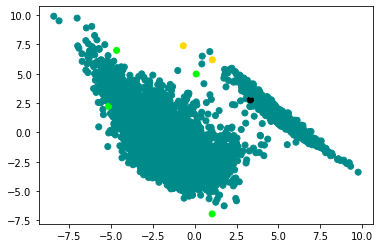

In [26]:
dbs_model = DBSCAN(eps=4, metric='euclidean', min_samples=2)
dbs_model.fit(df)
dbs_segments = pd.Series(dbs_model.labels_)

colorlist = [colors[s] for s in dbs_segments]
plt.scatter(pcax, pcay, c=colorlist)

Spectral Clustering and DBSCAN appear to be inappropriate for the data, which perhaps does not vary much in density.

So, we've narrowed down our models to K-Means or Agglomerative, and should decide whether the extra columns in our dataset would be useful to make business decisions. Let's make sure to run all options and look at them in one place before deciding.

In [105]:
km5_model = KMeans(n_clusters=5, random_state=36)
km5_model.fit(df)
km5_labels = pd.Series(km5_model.labels_)
km5_sil = silhouette_score(df, km5_labels)

ac4_model = AgglomerativeClustering(n_clusters=4, linkage='ward')
ac4_model.fit(df)
ac4_labels = pd.Series(ac4_model.labels_)
ac4_sil = silhouette_score(df, ac4_labels)

ac5_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
ac5_model.fit(df)
ac5_labels = pd.Series(ac5_model.labels_)
ac5_sil = silhouette_score(df, ac5_labels)

rfm_ac_model = AgglomerativeClustering(n_clusters=4)
rfm_ac_model.fit(rfm)
rfm_ac_labels = pd.Series(rfm_ac_model.labels_)
rfm_ac_sil = silhouette_score(rfm, rfm_ac_labels)

In [111]:
models_df = pd.DataFrame({"model_var":['km3_model', 'km4_model', 'km5_model', 'rfm_km_model', 'ac3_model', 'ac4_model', 'ac5_model', 'rfm_ac_model'],
                          "model_type":['kmeans', 'kmeans', 'kmeans', 'kmeans', 'agglomerative', 'agglomerative', 'agglomerative', 'agglomerative'], 
                          "n_clusters":[3, 4, 5, 4, 3, 4, 5, 4], 
                          "datasource":['df', 'df', 'df', 'rfm', 'df', 'df', 'df', 'rfm'], 
                          "sil_score":[km3_sil, km4_sil, km5_sil, rfm_km_sil, ac3_sil, ac4_sil, ac5_sil, rfm_ac_sil]})
models_df.sort_values('sil_score', ascending=False)

,model_var,model_type,n_clusters,datasource,sil_score
3,rfm_km_model,kmeans,4,rfm,0.365525
0,km3_model,kmeans,3,df,0.345870
4,ac3_model,agglomerative,3,df,0.314245
7,rfm_ac_model,agglomerative,4,rfm,0.307401
1,km4_model,kmeans,4,df,0.289265
5,ac4_model,agglomerative,4,df,0.262795
2,km5_model,kmeans,5,df,0.218911
6,ac5_model,agglomerative,5,df,0.183211


Based on silhouette score alone, the classic RFM analysis we interpreted above, using K-Means clustering, is the best grouping of the data. We'll be sure to save that interpretation as one option for presentation. However, I think it is still worth considering the other models, which have the benefit of additional information in the dataset. 

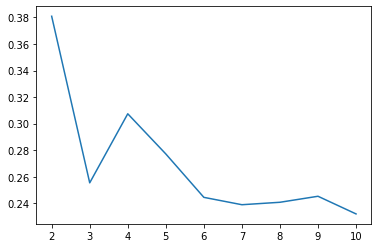

In [38]:
sil = []
for k in ks:
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    labels = model.fit(rfm).labels_
    sil.append(silhouette_score(rfm, labels))

plt.plot(ks, sil)

Silhouette Score:  0.3074012623782015


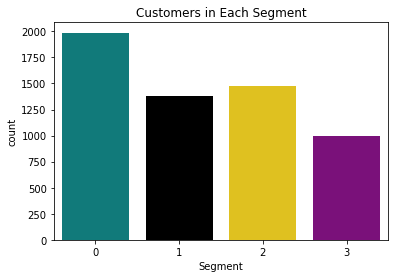

In [102]:
rfm_ac_model = AgglomerativeClustering(n_clusters=4)
rfm_ac_model.fit(rfm)
rfm_ac_labels = pd.Series(rfm_ac_model.labels_)
rfm_ac_sil = silhouette_score(rfm, rfm_ac_labels)

print("Silhouette Score: ",rfm_ac_sil)

sns.countplot(x=rfm_ac_labels, palette=colors[:4])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

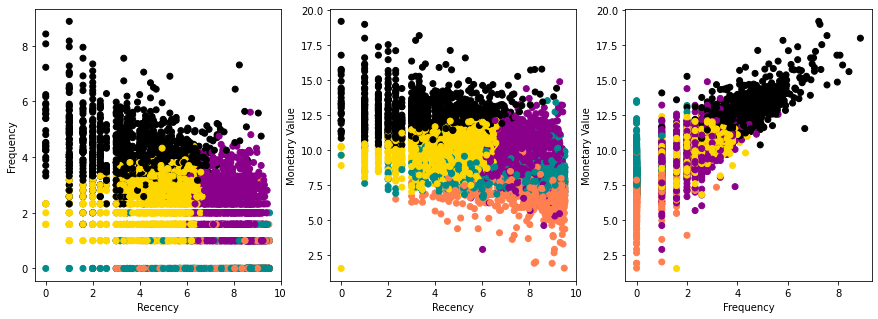

In [109]:
colorlist = [colors[s] for s in km5_labels]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(rfm.recency, rfm.orders, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(rfm.recency, rfm.total_value, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Monetary Value')

plt.subplot(1, 3, 3)
plt.scatter(rfm.orders, rfm.total_value, c=colorlist)
plt.xlabel('Frequency')
plt.ylabel('Monetary Value');

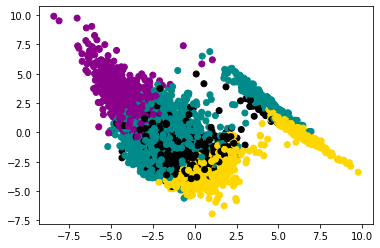

In [84]:
plt.scatter(pcax, pcay, c=colorlist);